In [1]:
%matplotlib inline

In [2]:
# ML and numerical libraries
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# DANN paper implementation helpers
from flip_gradient import flip_gradient
from utils import *

# Text processing
from sklearn.feature_extraction.text import CountVectorizer

# Data visualization
from sklearn.manifold import TSNE

In [3]:
# Mandatory for CUDA, NVIDIA, Linux Mint compatibility with middle-level TF code
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
# Read and preprocess datasets
source_df = one_hot_eyewitness(
    pd.read_csv(
        'datasets/datasets-eyewitness/EyewitnessTweetsFromCrisisT26/CrisisLexT26_FloodsTraining_EN.csv'))
target_df = one_hot_eyewitness(
    pd.read_csv(
        'datasets/datasets-eyewitness/EyewitnessTweetsFromCrisisT26/CrisisLexT26_FloodsTest_EN.csv'))

source_examples = preprocess_text(source_df['sentence'])
source_labels = source_df[['Eyewitness', 'NotEyewitness']]

target_examples = preprocess_text(target_df['sentence'])
target_labels = target_df[['Eyewitness', 'NotEyewitness']]

In [5]:
source_df.head()

,sentence,Eyewitness,NotEyewitness
0,Philippine floods worsen as death toll hits 14...,0,1
1,RT @gmanews: Philippine floods worsen as death...,0,1
2,4 Luzon dams release water; flood warning up: ...,0,1
3,RT @ANCALERTS: PAGASA 8:50pm advisory: Yellow ...,0,1
4,@ANCALERTS: PAGASA 8:50pm advisory: Yellow war...,0,1


In [6]:
# Set max_features size as the input convolutional matrix size
cv = CountVectorizer(max_features=35*35*5)

# Fit on the training examples and transform the datasets
cv.fit(source_examples)
X = cv.transform(source_examples).todense()
X_target = cv.transform(target_examples).todense()

# Change shape to convolutional matrix
X = np.array(X).reshape((X.shape[0], 35, 35, 5))
X_target = np.array(X_target).reshape((X_target.shape[0], 35, 35, 5))

# Split training and testing data
X_source_train, X_source_test, y_source_train, y_source_test = \
    train_test_split(X, source_labels, test_size=0.3, random_state=42)
X_target_train, X_target_test, y_target_train, y_target_test = \
    train_test_split(X_target, target_labels, test_size=0.3, random_state=42)

In [7]:
# Create a mixed dataset for TSNE visualization
num_test = 150
combined_test_imgs = np.vstack([X_source_test[:num_test], X_target_test[:num_test]])
combined_test_labels = np.vstack([y_source_test[:num_test], y_target_test[:num_test]])
combined_test_domain = np.vstack([np.tile([1., 0.], [num_test, 1]),
        np.tile([0., 1.], [num_test, 1])])

In [8]:
batch_size = 128

class DANN_Model(object):
    """Domain adaptation model."""
    def __init__(self):
        self._build_model()

    def _build_model(self):
        self.X = tf.placeholder(tf.uint8, [None, 35, 35, 5])
        self.y = tf.placeholder(tf.float32, [None, 2])
        self.domain = tf.placeholder(tf.float32, [None, 2])
        self.l = tf.placeholder(tf.float32, [])
        self.train = tf.placeholder(tf.bool, [])
        
        # CNN model for feature extraction
        with tf.variable_scope('feature_extractor'):

            W_conv0 = weight_variable([5, 5, 5, 32])
            b_conv0 = bias_variable([32])
            h_conv0 = tf.nn.relu(conv2d(tf.cast(self.X, tf.float32), W_conv0) + b_conv0)
            h_pool0 = max_pool_2x2(h_conv0)
            
            W_conv1 = weight_variable([5, 5, 32, 48])
            b_conv1 = bias_variable([48])
            h_conv1 = tf.nn.relu(conv2d(h_pool0, W_conv1) + b_conv1)
            h_pool1 = max_pool_2x2(h_conv1)
            
            # The domain-invariant feature
            self.feature = tf.reshape(h_pool1, [-1, 9*9*48])

        # MLP for class prediction
        with tf.variable_scope('label_predictor'):
            
            # Switches to route target examples (second half of batch) differently
            # depending on train or test mode.
            all_features = lambda: self.feature
            source_features = lambda: tf.slice(self.feature, [0, 0], [batch_size // 2, -1])
            classify_feats = tf.cond(self.train, source_features, all_features)
            
            all_labels = lambda: self.y
            source_labels = lambda: tf.slice(self.y, [0, 0], [batch_size // 2, -1])
            self.classify_labels = tf.cond(self.train, source_labels, all_labels)
            
            W_fc0 = weight_variable([9 * 9 * 48, 100])
            b_fc0 = bias_variable([100])
            h_fc0 = tf.nn.relu(tf.matmul(classify_feats, W_fc0) + b_fc0)

            W_fc1 = weight_variable([100, 100])
            b_fc1 = bias_variable([100])
            h_fc1 = tf.nn.relu(tf.matmul(h_fc0, W_fc1) + b_fc1)

            W_fc2 = weight_variable([100, 2])
            b_fc2 = bias_variable([2])
            logits = tf.matmul(h_fc1, W_fc2) + b_fc2
            
            self.pred = tf.nn.softmax(logits)
            self.pred_loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=self.classify_labels)

        # Small MLP for domain prediction with adversarial loss
        with tf.variable_scope('domain_predictor'):
            
            # Flip the gradient when backpropagating through this operation
            feat = flip_gradient(self.feature, self.l)
            
            d_W_fc0 = weight_variable([9 * 9 * 48, 100])
            d_b_fc0 = bias_variable([100])
            d_h_fc0 = tf.nn.relu(tf.matmul(feat, d_W_fc0) + d_b_fc0)
            
            d_W_fc1 = weight_variable([100, 2])
            d_b_fc1 = bias_variable([2])
            d_logits = tf.matmul(d_h_fc0, d_W_fc1) + d_b_fc1
            
            self.domain_pred = tf.nn.softmax(d_logits)
            self.domain_loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=d_logits, labels=self.domain)


In [9]:
# Build the model graph
graph = tf.compat.v1.get_default_graph()
with graph.as_default():
    model = DANN_Model()
    
    # Training
    learning_rate = tf.placeholder(tf.float32, [])
    
    pred_loss = tf.reduce_mean(model.pred_loss)
    domain_loss = tf.reduce_mean(model.domain_loss)
    total_loss = pred_loss + domain_loss

    regular_train_op = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(pred_loss)
    dann_train_op = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(total_loss)
    
    # Evaluation
    correct_label_pred = tf.equal(tf.argmax(model.classify_labels, 1), tf.argmax(model.pred, 1))
    label_acc = tf.reduce_mean(tf.cast(correct_label_pred, tf.float32))
    correct_domain_pred = tf.equal(tf.argmax(model.domain, 1), tf.argmax(model.domain_pred, 1))
    domain_acc = tf.reduce_mean(tf.cast(correct_domain_pred, tf.float32))


In [10]:
def train_and_evaluate(training_mode, graph, model, num_steps=10000, verbose=True):
    """Helper to run the model with different training modes."""

#     with session as sess:
    tf.global_variables_initializer().run()

    # Batch generators
    gen_source_batch = batch_generator(
        [X_source_train, y_source_train], batch_size // 2)
    gen_target_batch = batch_generator(
        [X_target_train, y_target_train], batch_size // 2)
    gen_source_only_batch = batch_generator(
        [X_source_train, y_source_train], batch_size)
    gen_target_only_batch = batch_generator(
        [X_target_train, y_target_train], batch_size)

    domain_labels = np.vstack([np.tile([1., 0.], [batch_size // 2, 1]),
                               np.tile([0., 1.], [batch_size // 2, 1])])

    # Training loop
    for i in range(num_steps):
        if i % 500 == 0:
            print('step {0} out of {1}'.format(i, num_steps))
        # Adaptation param and learning rate schedule as described in the paper
        p = float(i) / num_steps
        l = 2. / (1. + np.exp(-10. * p)) - 1
        lr = 0.01 / (1. + 10 * p)**0.75

        # Training step
        if training_mode == 'dann':

            X0, y0 = next(gen_source_batch)
            X1, y1 = next(gen_target_batch)
            X = np.vstack([X0, X1])
            y = np.vstack([y0, y1])

            _, batch_loss, dloss, ploss, d_acc, p_acc = sess.run(
                [dann_train_op, total_loss, domain_loss, pred_loss, domain_acc, label_acc],
                feed_dict={model.X: X, model.y: y, model.domain: domain_labels,
                           model.train: True, model.l: l, learning_rate: lr})

            if verbose and i % 100 == 0:
                print('loss: {}  d_acc: {}  p_acc: {}  p: {}  l: {}  lr: {}'.format(
                        batch_loss, d_acc, p_acc, p, l, lr))

        elif training_mode == 'source':
            X, y = next(gen_source_only_batch)
            _, batch_loss = sess.run([regular_train_op, pred_loss],
                                 feed_dict={model.X: X, model.y: y, model.train: False,
                                            model.l: l, learning_rate: lr})

        elif training_mode == 'target':
            X, y = next(gen_target_only_batch)
            _, batch_loss = sess.run([regular_train_op, pred_loss],
                                 feed_dict={model.X: X, model.y: y, model.train: False,
                                            model.l: l, learning_rate: lr})

    # Compute final evaluation on test data
    source_acc = sess.run(label_acc,
                        feed_dict={model.X: X_source_test, model.y: y_source_test,
                                   model.train: False})

    target_acc = sess.run(label_acc,
                        feed_dict={model.X: X_target_test, model.y: y_target_test,
                                   model.train: False})

    test_domain_acc = sess.run(domain_acc,
                        feed_dict={model.X: combined_test_imgs,
                                   model.domain: combined_test_domain, model.l: 1.0})

    test_emb = sess.run(model.feature, feed_dict={model.X: combined_test_imgs})
    return source_acc, target_acc, test_domain_acc, test_emb


print('\nSource only training')
source_acc, target_acc, _, source_only_emb = train_and_evaluate('source', graph, model)
print('Source accuracy:', source_acc)
print('Target accuracy:', target_acc)

print('\nDomain adaptation training')
source_acc, target_acc, d_acc, dann_emb = train_and_evaluate('dann', graph, model)
print('Source accuracy:', source_acc)
print('Target accuracy:', target_acc)
print('Domain accuracy:', d_acc)


Source only training
step 0 out of 10000
step 500 out of 10000
step 1000 out of 10000
step 1500 out of 10000
step 2000 out of 10000
step 2500 out of 10000
step 3000 out of 10000
step 3500 out of 10000
step 4000 out of 10000
step 4500 out of 10000
step 5000 out of 10000
step 5500 out of 10000
step 6000 out of 10000
step 6500 out of 10000
step 7000 out of 10000
step 7500 out of 10000
step 8000 out of 10000
step 8500 out of 10000
step 9000 out of 10000
step 9500 out of 10000
Source accuracy: 0.7902439
Target accuracy: 0.82

Domain adaptation training
step 0 out of 10000
loss: 1.6827819347381592  d_acc: 0.4921875  p_acc: 0.34375  p: 0.0  l: 0.0  lr: 0.01
loss: 1.0988967418670654  d_acc: 0.7578125  p_acc: 0.75  p: 0.01  l: 0.049958374957880025  lr: 0.009310124446222229
loss: 0.9131938219070435  d_acc: 0.796875  p_acc: 0.78125  p: 0.02  l: 0.0996679946249559  lr: 0.008721959494934213
loss: 1.1689398288726807  d_acc: 0.65625  p_acc: 0.8125  p: 0.03  l: 0.14888503362331806  lr: 0.008213769018

loss: 1.315522313117981  d_acc: 0.5  p_acc: 0.703125  p: 0.66  l: 0.9972829600991422  lr: 0.0021846899245689844
loss: 1.2573823928833008  d_acc: 0.5  p_acc: 0.75  p: 0.67  l: 0.9975412027574453  lr: 0.0021633757443878074
loss: 1.2377617359161377  d_acc: 0.5  p_acc: 0.765625  p: 0.68  l: 0.9977749279342796  lr: 0.002142540539124344
loss: 1.2185052633285522  d_acc: 0.5  p_acc: 0.78125  p: 0.69  l: 0.9979864583598288  lr: 0.0021221676089642014
step 7000 out of 10000
loss: 1.1254172325134277  d_acc: 0.5  p_acc: 0.859375  p: 0.7  l: 0.9981778976111988  lr: 0.0021022410381342864
loss: 1.2380471229553223  d_acc: 0.5  p_acc: 0.765625  p: 0.71  l: 0.9983511506272034  lr: 0.002082745648853145
loss: 1.0885064601898193  d_acc: 0.5  p_acc: 0.890625  p: 0.72  l: 0.9985079423323266  lr: 0.00206366695851539
loss: 1.1990103721618652  d_acc: 0.5  p_acc: 0.796875  p: 0.73  l: 0.9986498345387345  lr: 0.002044991139846808
loss: 1.180840015411377  d_acc: 0.5  p_acc: 0.8125  p: 0.74  l: 0.9987782412811312  l

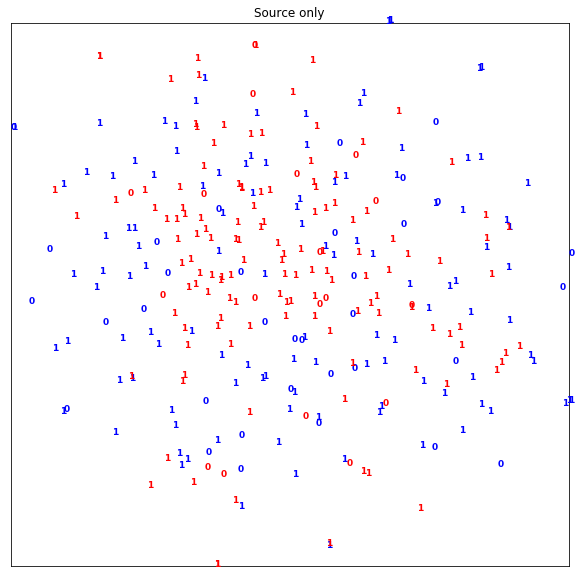

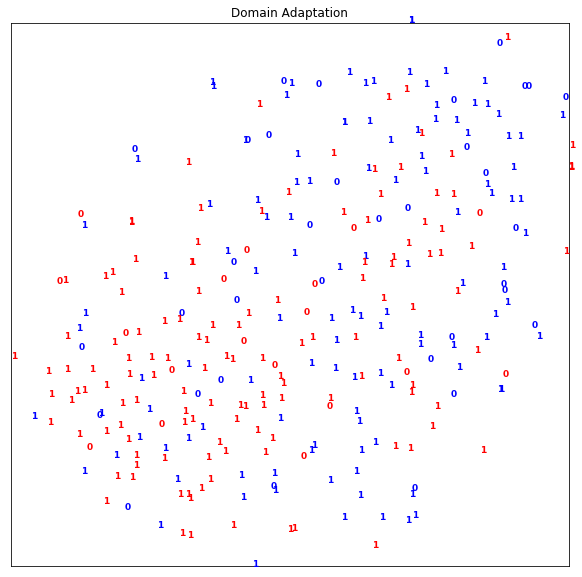

In [11]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
source_only_tsne = tsne.fit_transform(source_only_emb)

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
dann_tsne = tsne.fit_transform(dann_emb)
        
plot_embedding(source_only_tsne, combined_test_labels.argmax(1), combined_test_domain.argmax(1), 'Source only')
plot_embedding(dann_tsne, combined_test_labels.argmax(1), combined_test_domain.argmax(1), 'Domain Adaptation')

In [12]:
sess.close()